# Load and clean Dataset

In [1]:
import pandas as pd
import torch

OSError: [WinError 126] The specified module could not be found. Error loading "c:\Users\shawn\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

In [2]:
df=pd.read_csv('oversampled_dataset_3labels.csv')

In [3]:
df=df.drop('Unnamed: 0', axis=1)

In [4]:
df.head()

,desired_answer,student_answer,label
0,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,1
1,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,2
2,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,1
3,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,2
4,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,1


In [6]:
import re
PATTERN_S = re.compile("\'s")  # matches `'s` from text  
PATTERN_RN = re.compile("\\r\\n") #matches `\r` and `\n`
PATTERN_PUNC = re.compile(r"[^\w\s]") # matches all non 0-9 A-z whitespace 

In [7]:
def clean_text(text):
    text = text.lower() 
    # replace the matched string with ' '
    text = re.sub(PATTERN_S, ' ', text)
    text = re.sub(PATTERN_RN, ' ', text)
    text = re.sub(PATTERN_PUNC, ' ', text)
    return text

In [8]:
def clean_sentences(df):
    print('Cleaning sentences...')
    df['desired_answer'] = df['desired_answer'].apply(clean_text)
    df['student_answer'] = df['student_answer'].apply(clean_text)
    return df

In [9]:
df = clean_sentences(df)

Cleaning sentences...


In [10]:
df.head()

,desired_answer,student_answer,label
0,to simulate the behaviour of portions of the d...,high risk problems are address in the prototyp...,1
1,to simulate the behaviour of portions of the d...,to simulate portions of the desired final prod...,2
2,to simulate the behaviour of portions of the d...,a prototype program simulates the behaviors of...,1
3,to simulate the behaviour of portions of the d...,defined in the specification phase a prototype...,2
4,to simulate the behaviour of portions of the d...,it is used to let the users have a first idea ...,1


# Install Hugging and datasets libraries
# !pip install --upgrade transformers datasets accelerate

In [11]:
from datasets import Dataset, DatasetDict

c:\Users\shawn\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
import torch


In [13]:
dataset = Dataset.from_pandas(df)
dataset.set_format("pt")

In [14]:
item = dataset[0]
print(item)

{'desired_answer': 'to simulate the behaviour of portions of the desired software product ', 'student_answer': 'high risk problems are address in the prototype program to make sure that the program is feasible   a prototype may also be used to show a company that the software can be possibly programmed ', 'label': tensor(1)}


In [15]:
dataset

Dataset({
    features: ['desired_answer', 'student_answer', 'label'],
    num_rows: 5259
})

# Load tokenizer and tokenize dataset

In [16]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [17]:
#Example Usage
# Example text
text = "BERT is a powerful NLP model."

# Tokenize the text
tokens = tokenizer(text)

print(tokens)


{'input_ids': [101, 14324, 2003, 1037, 3928, 17953, 2361, 2944, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [18]:
def preprocess_function(examples):
    return tokenizer(examples["desired_answer"], examples["student_answer"], padding="max_length", truncation=True)

In [19]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 5259/5259 [00:01<00:00, 4541.21 examples/s]


In [20]:
tokenized_dataset

Dataset({
    features: ['desired_answer', 'student_answer', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5259
})

In [21]:
tokenized_dataset[:3]

{'desired_answer': ['to simulate the behaviour of portions of the desired software product ',
  'to simulate the behaviour of portions of the desired software product ',
  'to simulate the behaviour of portions of the desired software product '],
 'student_answer': ['high risk problems are address in the prototype program to make sure that the program is feasible   a prototype may also be used to show a company that the software can be possibly programmed ',
  'to simulate portions of the desired final product with a quick and easy program that does a small specific job  it is a way to help see what the problem is and how you may solve it in the final project ',
  'a prototype program simulates the behaviors of portions of the desired software product to allow for error checking '],
 'label': tensor([1, 2, 1]),
 'input_ids': tensor([[  101,  2000, 26633,  ...,     0,     0,     0],
         [  101,  2000, 26633,  ...,     0,     0,     0],
         [  101,  2000, 26633,  ...,     0,   

Split data into train and test

In [22]:
train_test = tokenized_dataset.train_test_split(test_size=0.3, seed=1178435)
train_test

DatasetDict({
    train: Dataset({
        features: ['desired_answer', 'student_answer', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3681
    })
    test: Dataset({
        features: ['desired_answer', 'student_answer', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1578
    })
})

In [23]:
val_test = train_test['test'].train_test_split(test_size=0.5,)
val_test

DatasetDict({
    train: Dataset({
        features: ['desired_answer', 'student_answer', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 789
    })
    test: Dataset({
        features: ['desired_answer', 'student_answer', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 789
    })
})

See if there is any model answers that appear in both training and test datasets

In [24]:
for a, b in zip(train_test['test']['desired_answer'],train_test['train']['desired_answer']):
  if a==b:
    print('yes')

yes
yes
yes
yes
yes
yes


# visualize the data

In [25]:
df_train = pd.DataFrame( train_test['train'] )
df_test = pd.DataFrame( train_test['test'] )

In [26]:
df_train['label']=df_train['label'].apply(lambda x:x.numpy())
df_test['label']=df_test['label'].apply(lambda x:x.numpy())

C:\Users\shawn\AppData\Local\Temp\ipykernel_19080\3694777759.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_train['label']).plot.bar()


<Axes: xlabel='label'>

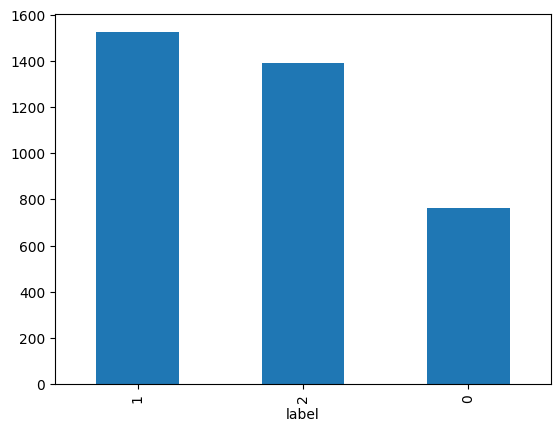

In [27]:
pd.value_counts(df_train['label']).plot.bar()

C:\Users\shawn\AppData\Local\Temp\ipykernel_19980\3767985700.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_test['label']).plot.bar()


<Axes: xlabel='label'>

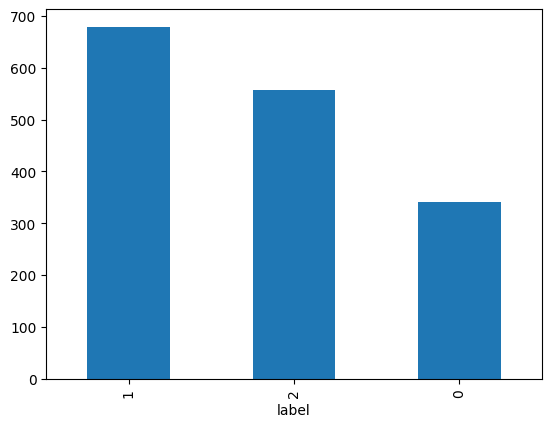

In [26]:
pd.value_counts(df_test['label']).plot.bar()

# Download the model and start Training

In [28]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [29]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [30]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available


False


In [32]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3).to("cpu")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    optim="adafactor",
    num_train_epochs=8,
    weight_decay=0.01,
)

In [35]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay

In [36]:
y_preds = []
y_trues = []

In [37]:
def compute_metrics(eval_pred):
  pred, labels=eval_pred
  pred=np.argmax(pred,axis=1)

  acc=accuracy_score(labels,pred)
  f_score=f1_score(labels, pred, average='weighted')
  cohen_score = cohen_kappa_score(labels, pred)

  y_preds.append(pred)
  y_trues.append(labels)

  return {'acc':acc, 'f_score':f_score, 'cohen_score':cohen_score}

In [38]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test['train'],
    eval_dataset=val_test['train'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [39]:
trainer.train()

  2%|▏         | 43/1848 [23:33<16:33:15, 33.02s/it]

KeyboardInterrupt: 

# Evaluate Model

In [ ]:
trainer.evaluate()

In [ ]:
trainer.evaluate(val_test['test'])

# Confusion Matrix

In [ ]:
from keras.utils import to_categorical
num_classes = 5
y_categorial = to_categorical(y_preds, num_classes)
y_pred = y_categorial.argmax(1)

In [ ]:
y_trues_cat = to_categorical(y_trues, num_classes)
y_true=y_trues_cat.argmax(1)

In [ ]:
y_test_non_category = [int(np.argmax(t)) for t in y_trues_cat.tolist()[0] ]
y_predict_non_category = [ int(np.argmax(t)) for t in y_categorial.tolist()[0] ]

In [ ]:
confusion = confusion_matrix(y_test_non_category,y_predict_non_category)

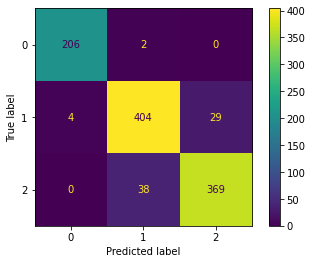

In [ ]:
import matplotlib.pyplot as plt
disp=ConfusionMatrixDisplay(confusion)
disp.plot()
plt.show()

# predict and save model

In [ ]:
model = model.to('cpu')

In [ ]:
inputs = tokenizer("A computer is a machine that can be programmed to carry out sequences of arithmetic or logical operations automatically", "I don't know", padding="max_length", truncation=True, return_tensors="pt")

In [ ]:
import torch
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'LABEL_0'

In [ ]:
model.save_pretrained('/model')

Configuration saved in /content/model/config.json
Model weights saved in /content/model/pytorch_model.bin
